In [1]:
import xarray as xr
from eofs.xarray import Eof
import numpy as np
import pandas as pd
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.stats import pearsonr

### Data 

In [2]:
# Open HadISST 
sst_ds = xr.open_dataset('/g/data/w40/rl5183/hadisst.1870_2017_1.5x1.5.nc')
sst = sst_ds.sst.sel(lat=slice(-30,30)).sel(lon=slice(120,270)).sel(time=slice('1900-01', '2014-12'))
# Detrend 
sst_detrend = np.apply_along_axis(func.detrend_2step, 0, sst)
sst_dt = xr.DataArray(sst_detrend, coords=sst.coords, attrs=sst.attrs)

In [3]:
zon_grad_1 = sst.sel(time=slice('1900-01', '1929-12')).sel(lat=slice(-5,5)).sel(lon=slice(160, 270)).mean(dim=['lat', 'time'])
zon_grad_2 = sst.sel(time=slice('1985-01', '2014-12')).sel(lat=slice(-5,5)).sel(lon=slice(160, 270)).mean(dim=['lat', 'time'])
zon_grad_change = zon_grad_2 - zon_grad_1

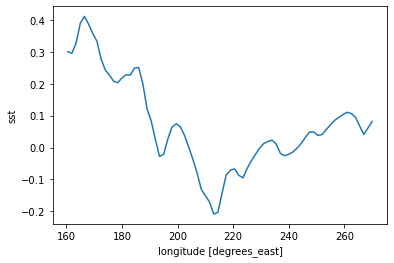

In [4]:
zon_grad_change.plot()

In [5]:
# Calculate Nino34 index
nino34 = func.nino34_index(sst_dt, '1979-01', '2008-12')
# Calculate monthly anomalies 
clim = sst.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
anom = sst.groupby('time.month') - clim
# Calculate EOFs
eof, pcs, var = func.eof_and_pcs(anom, 3)

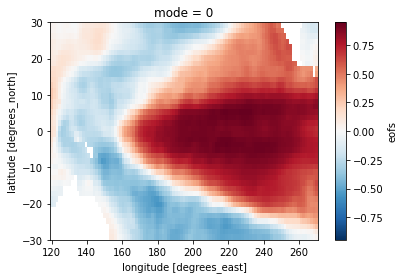

In [6]:
# Investigate eofs
(eof.sel(mode=0)*-1).plot()

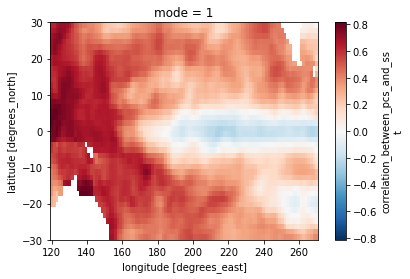

In [7]:
(eof.sel(mode=1)).plot()

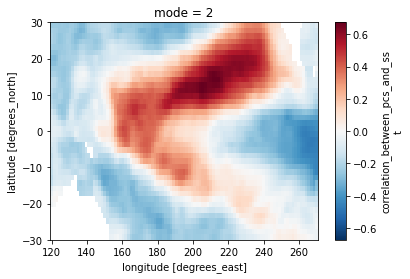

In [8]:
eof.sel(mode=2).plot()

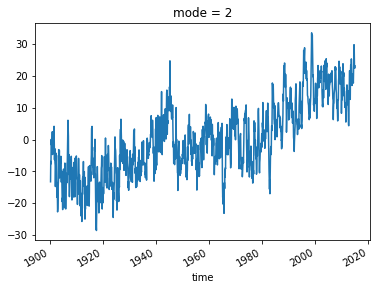

In [9]:
pcs.sel(mode=2).plot()

In [10]:
var

<xarray.DataArray 'variance_fractions' (mode: 3)>
array([0.39413294, 0.1372131 , 0.07344409], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2
Attributes:
    long_name:  variance_fractions

In [16]:
# Normalise pcs
pc1 = pcs.sel(mode=1)*(-1)
std1 = pc1.std() # Takhashi usues standrd deviatuion of base period 
pc1 = pc1/std1

pc2 = pcs.sel(mode=3)
std2 = pc2.std()
pc2 = pc2/std2

# Seasonal index 
func.seasonyear(pc1)
seasonal_pc1 = pc1.groupby('seasonyear').apply(func.seasonal_mean)
djf_pc1 = seasonal_pc1.sel(season='DJF')

func.seasonyear(pc2)
seasonal_pc2 = pc2.groupby('seasonyear').apply(func.seasonal_mean)
djf_pc2 = seasonal_pc2.sel(season='DJF')

# Get years 
EP_years_eof = djf_pc1.where((djf_pc1 > djf_pc2) & (djf_pc1>1.2), drop=True)
CP_years_eof = djf_pc2.where((djf_pc2 > djf_pc1) & (djf_pc2>1.2), drop=True)

In [17]:
CP_years_eof

<xarray.DataArray (seasonyear: 13)>
array([1.20555891, 1.32720804, 1.29787689, 2.01441655, 1.31625368,
       2.56072697, 1.71247448, 1.2448748 , 1.49237684, 1.38867468,
       1.2860835 , 1.46923049, 1.53983038])
Coordinates:
    season      <U3 'DJF'
    mode        int64 3
  * seasonyear  (seasonyear) int64 1916 1930 1947 1959 ... 1981 1986 1991 1993

### El Nino and La Nina 

In [4]:
# El Nino, La Nina years 

# Using SST method 
el_nino_years_sst, la_nina_years_sst = func.find_event_years(nino34, 0.4, 6)

# Using EOF method 

# Normalise pcs
pc1 = pcs.sel(mode=1)*(-1)
std1 = pc1.std() # Takhashi usues standrd deviatuion of base period 
pc1 = pc1/std1

# Methods from Perry et. al 2020 - normalised PC1 amplitude exceeds +/- 0.75
func.seasonyear(pc1)
seasonal_pc1 = pc1.groupby('seasonyear').apply(func.seasonal_mean)
djf_pc1 = seasonal_pc1.sel(season='DJF')
el_nino_years_eof = djf_pc1.where(djf_pc1>0.75, drop=True).seasonyear
la_nina_years_eof = djf_pc1.where(djf_pc1<-0.75, drop=True).seasonyear
# Remeber to minus 1 when printing out years as december is pushed over to next year 

In [5]:
# El Nino, La Nina composites 

# Using SST method 
el_nino_comp_sst, la_nina_comp_sst = func.sst_comp(nino34, sst_dt, 'DJF')

# Using EOF method
# Add season year axis to sst data 
func.seasonyear(sst_dt)
# Calculate seasonal means 
seasonal_sst = sst_dt.groupby('seasonyear').apply(func.seasonal_mean)
# Select out season
sst_djf = seasonal_sst.sel(season='DJF')
# Find composite 
el_nino_comp_eof = (sst_djf.sel(seasonyear=el_nino_years_eof) - sst_djf.mean(dim='seasonyear')).mean(dim='seasonyear')
la_nina_comp_eof = (sst_djf.sel(seasonyear=la_nina_years_eof) - sst_djf.mean(dim='seasonyear')).mean(dim='seasonyear')

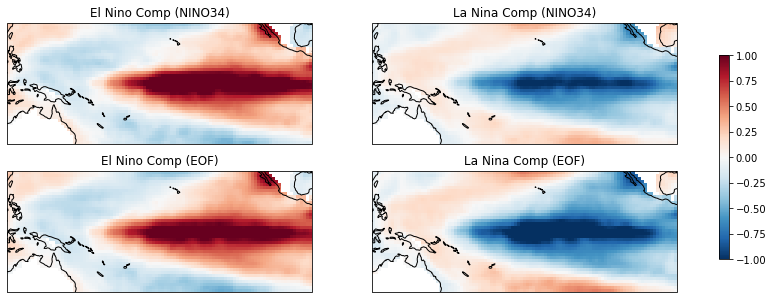

In [6]:
fig = plt.figure(figsize = (15,5)) 
axs = []
ax = fig.add_subplot(221, projection=ccrs.PlateCarree(180))
im = el_nino_comp_sst.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Nino Comp (NINO34)')
axs.append(ax)
ax = fig.add_subplot(222, projection=ccrs.PlateCarree(180))
im = la_nina_comp_sst.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Nina Comp (NINO34)')
axs.append(ax)
ax = fig.add_subplot(223, projection=ccrs.PlateCarree(180))
im = el_nino_comp_eof.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Nino Comp (EOF)')
axs.append(ax)
ax = fig.add_subplot(224, projection=ccrs.PlateCarree(180))
im = la_nina_comp_eof.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Nina Comp (EOF)')
axs.append(ax)
cbar = plt.colorbar(im, ax=axs, shrink=0.75, pad=0.05)
#plt.savefig('enso_comp_nino34_eof.jpg', bbox_inches='tight', dpi=300)

In [14]:
# Pattern corr
# Make 1d
el_nino_comp_sst_1d = el_nino_comp_sst.values.flatten()
la_nina_comp_sst_1d = la_nina_comp_sst.values.flatten()
el_nino_comp_eof_1d = el_nino_comp_eof.values.flatten()
la_nina_comp_eof_1d = la_nina_comp_eof.values.flatten()
# Apply mask 
el_nino_comp_sst_1d = el_nino_comp_sst_1d[np.isfinite(el_nino_comp_sst_1d)]
la_nina_comp_sst_1d = la_nina_comp_sst_1d[np.isfinite(la_nina_comp_sst_1d)]
el_nino_comp_eof_1d = el_nino_comp_eof_1d[np.isfinite(el_nino_comp_eof_1d)]
la_nina_comp_eof_1d = la_nina_comp_eof_1d[np.isfinite(la_nina_comp_eof_1d)]
# Correlation
el_nino_cor = pearsonr(el_nino_comp_sst_1d, el_nino_comp_eof_1d)
la_nina_cor = pearsonr(la_nina_comp_sst_1d, la_nina_comp_eof_1d)

In [20]:
print(f'El Nino Corr: {el_nino_cor[0]}, La Nina Corr: {la_nina_cor[0]}')

El Nino Corr: 0.9924815507392101, La Nina Corr: 0.9928985356785761


### EP and CP

In [6]:
# EP, CP years 

# Nino indices method
# Calculate Nino3 and Nino4
nino3 = func.nino3_index(sst_dt, '1979-01', '2008-12')
nino4 = func.nino4_index(sst_dt, '1979-01', '2008-12')
# Calculate EP and CP index
EP_sst = nino3 - 0.5*nino4
CP_sst = nino4 - 0.5*nino3
# Get EP and CP years 
seasonal_EP_sst = func.seasonal_mean_nino_index(EP_sst)
seasonal_CP_sst = func.seasonal_mean_nino_index(CP_sst)
djf_EP_sst = seasonal_EP_sst.sel(season='DJF')
djf_CP_sst = seasonal_CP_sst.sel(season='DJF')
EP_years_sst = djf_EP_sst.where(djf_EP_sst>0.5, drop=True)
CP_years_sst = djf_CP_sst.where(djf_CP_sst>0.5, drop=True)

In [13]:
CP_years_sst.seasonyear -1

<xarray.DataArray 'seasonyear' (seasonyear: 11)>
array([1941, 1977, 1986, 1987, 1990, 1991, 1994, 2002, 2004, 2006, 2009])
Coordinates:
    season      <U3 'DJF'
  * seasonyear  (seasonyear) int64 1942 1978 1987 1988 ... 2003 2005 2007 2010

In [8]:
# EOF method from Xu et al. 
# EP defined when standardised (DJF) PC1 > 1 std and > CP index (normalised (DJF) PC2)
# CP defined when standardised (DJF) PC2 > 0.8 std and > EP index (normalised (DJF) PC1)
# Normalise pc2
pc2 = pcs.sel(mode=2)
std2 = pc2.std()
pc2 = pc2/std2
# Seasonal index 
func.seasonyear(pc2)
seasonal_pc2 = pc2.groupby('seasonyear').apply(func.seasonal_mean)
djf_pc2 = seasonal_pc2.sel(season='DJF')
# Get years 
EP_years_eof = djf_pc1.where((djf_pc1 > djf_pc2) & (djf_pc1>1), drop=True)
CP_years_eof = djf_pc2.where((djf_pc2 > djf_pc1) & (djf_pc2>0.8), drop=True)

In [12]:
EP_years_eof.seasonyear -1

<xarray.DataArray 'seasonyear' (seasonyear: 23)>
array([1899, 1902, 1904, 1905, 1911, 1914, 1918, 1925, 1930, 1939, 1940,
       1941, 1957, 1965, 1972, 1982, 1986, 1987, 1991, 1994, 1997, 2002,
       2009])
Coordinates:
    season      <U3 'DJF'
    mode        int64 1
  * seasonyear  (seasonyear) int64 1900 1903 1905 1906 ... 1995 1998 2003 2010

In [17]:
# E-index and C-index from Takahashi et al. 
E = (djf_pc1 - djf_pc2)/np.sqrt(2)
C = (djf_pc1 + djf_pc2)/np.sqrt(2)
# Get years 
E_years = E.where((E>1) & (E>C), drop=True)
C_years = C.where((C>0.8) & (C>E), drop=True)

In [26]:
C_years.seasonyear -1 

<xarray.DataArray 'seasonyear' (seasonyear: 26)>
array([1900, 1902, 1904, 1914, 1926, 1927, 1929, 1939, 1940, 1941, 1946,
       1957, 1958, 1968, 1977, 1979, 1983, 1987, 1990, 1992, 1993, 1995,
       2002, 2004, 2009, 2014])
Coordinates:
    season      <U3 'DJF'
  * seasonyear  (seasonyear) int64 1901 1903 1905 1915 ... 2003 2005 2010 2015

In [10]:
def regress_nino(data, nino):
    """
    Returns the linear regression at each gridpoint of 'data' against 'nino'
    """
    
    import numpy as np
    import scipy.stats
    import xarray as xr
    
    # Get the nino values at the dates matching 'data'
    # nino = nino.sel(time=data.time)
    
    # Function to apply on each gridpoint
    def regress_gridpoint(data):
        return scipy.stats.linregress(nino, data)[0]
    
    # Apply the function on each gridpoint
    regression = np.apply_along_axis(regress_gridpoint, data.get_axis_num('seasonyear'), data)
    
    # This is just to get the correct coordinates for the output
    sample = data.mean('seasonyear')
    
    # Convert the numpy array back into xarray
    return xr.DataArray(regression, sample.coords)

In [11]:
# Regress E-index and C-index onto SST
E_regress = regress_nino(sst_djf, E)
C_regress = regress_nino(sst_djf, C)

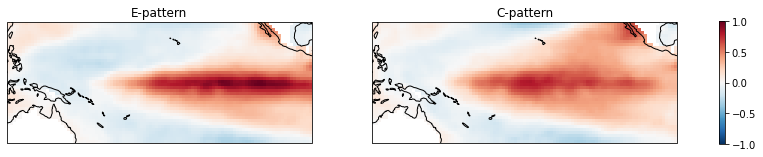

In [45]:
fig = plt.figure(figsize = (15,3)) 
axs = []
ax = fig.add_subplot(121, projection=ccrs.PlateCarree(180))
im = E_regress.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('E-pattern')
axs.append(ax)
ax = fig.add_subplot(122, projection=ccrs.PlateCarree(180))
im = C_regress.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('C-pattern')
axs.append(ax)
cbar = plt.colorbar(im, ax=axs, shrink=0.75, pad=0.05)
#plt.savefig('EP_CP_comp_cmip6.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

In [12]:
# Regress EP-index and CP-index onto SST (using nino based method)
# Get rid of nans 
djf_EP_sst_n = djf_EP_sst.fillna(0)
djf_CP_sst_n = djf_CP_sst.fillna(0)
# Regression
EP_regress = regress_nino(sst_djf, djf_EP_sst_n)
CP_regress = regress_nino(sst_djf, djf_CP_sst_n)

/local/eg3/rl5183/tmp/ipykernel_1557829/2050568444.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('E_C_pattern_eof_nino.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)
/local/eg3/rl5183/tmp/ipykernel_1557829/2050568444.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('E_C_pattern_eof_nino.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)
/local/eg3/rl5183/tmp/ipykernel_1557829/2050568444.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "progressive" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('E_C_pattern_eof_nino.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)


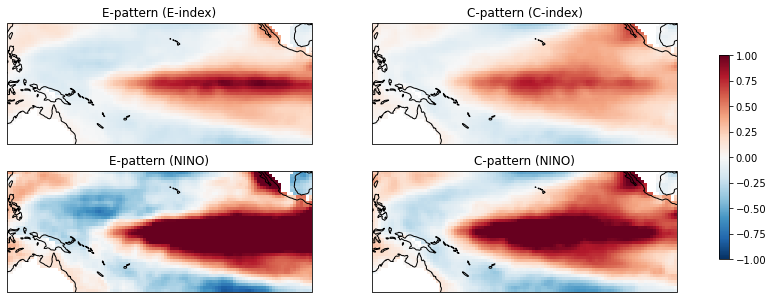

In [15]:
fig = plt.figure(figsize = (15,5)) 
axs = []
ax = fig.add_subplot(221, projection=ccrs.PlateCarree(180))
im = E_regress.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('E-pattern (E-index)')
axs.append(ax)
ax = fig.add_subplot(222, projection=ccrs.PlateCarree(180))
im = C_regress.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('C-pattern (C-index)')
axs.append(ax)
ax = fig.add_subplot(223, projection=ccrs.PlateCarree(180))
im = EP_regress.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('E-pattern (NINO)')
axs.append(ax)
ax = fig.add_subplot(224, projection=ccrs.PlateCarree(180))
im = CP_regress.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('C-pattern (NINO)')
axs.append(ax)
cbar = plt.colorbar(im, ax=axs, shrink=0.75, pad=0.05)
#plt.savefig('E_C_pattern_eof_nino.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

In [24]:
# Find composites using years (EOF method) 
ep_comp_eof = (sst_djf.sel(seasonyear=E_years.seasonyear) - sst_djf.mean(dim='seasonyear')).mean(dim='seasonyear')
cp_comp_eof = (sst_djf.sel(seasonyear=C_years.seasonyear) - sst_djf.mean(dim='seasonyear')).mean(dim='seasonyear')
# Find composites using years (NINO method) 
ep_comp_sst = (sst_djf.sel(seasonyear=EP_years_sst.seasonyear) - sst_djf.mean(dim='seasonyear')).mean(dim='seasonyear')
cp_comp_sst = (sst_djf.sel(seasonyear=CP_years_sst.seasonyear) - sst_djf.mean(dim='seasonyear')).mean(dim='seasonyear')

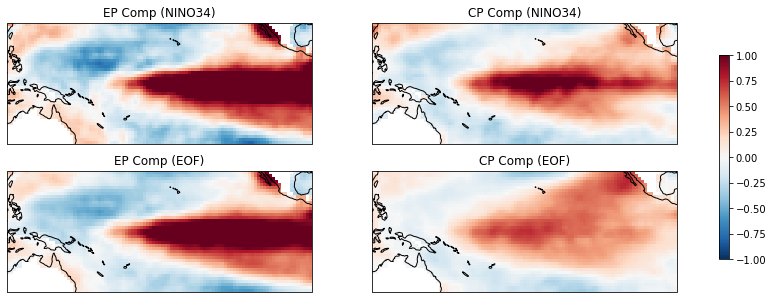

In [28]:
fig = plt.figure(figsize = (15,5)) 
axs = []
ax = fig.add_subplot(221, projection=ccrs.PlateCarree(180))
im = ep_comp_sst.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('EP Comp (NINO34)')
axs.append(ax)
ax = fig.add_subplot(222, projection=ccrs.PlateCarree(180))
im = cp_comp_sst.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('CP Comp (NINO34)')
axs.append(ax)
ax = fig.add_subplot(223, projection=ccrs.PlateCarree(180))
im = ep_comp_eof.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('EP Comp (EOF)')
axs.append(ax)
ax = fig.add_subplot(224, projection=ccrs.PlateCarree(180))
im = cp_comp_eof.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('CP Comp (EOF)')
axs.append(ax)
cbar = plt.colorbar(im, ax=axs, shrink=0.75, pad=0.05)
#plt.savefig('ep_cp_comp_nino34_eof.jpg', bbox_inches='tight', dpi=300)

In [26]:
# Pattern correlations
# Make 1d
ep_comp_sst_1d = ep_comp_sst.values.flatten()
cp_comp_sst_1d = cp_comp_sst.values.flatten()
ep_comp_eof_1d = ep_comp_eof.values.flatten()
cp_comp_eof_1d = cp_comp_eof.values.flatten()
# Apply mask 
ep_comp_sst_1d = ep_comp_sst_1d[np.isfinite(ep_comp_sst_1d)]
cp_comp_sst_1d = cp_comp_sst_1d[np.isfinite(cp_comp_sst_1d)]
ep_comp_eof_1d = ep_comp_eof_1d[np.isfinite(ep_comp_eof_1d)]
cp_comp_eof_1d = cp_comp_eof_1d[np.isfinite(cp_comp_eof_1d)]
# Correlation
ep_cor = pearsonr(ep_comp_sst_1d, ep_comp_eof_1d)
cp_cor = pearsonr(cp_comp_sst_1d, cp_comp_eof_1d)

In [27]:
print(f'EP Corr: {ep_cor[0]}, CP Corr: {cp_cor[0]}')

EP Corr: 0.9910530756184803, CP Corr: 0.8575321431522798
